In [1]:
import numpy as np
import matplotlib.pyplot as plt
import minimint
from sklearn.preprocessing import StandardScaler

# Introduction

Here we want to fit an isochrone to the data, using the fact that we expect the distribution to have a main gaussian component perpendicular to the main sequence and a cut off further. To automate this we will need to consider:
1. How we define the cut off of the main sequence.
2. Are the parameters fine tuned enough, we need to look at the code and documentation of the files we use.

For the moment we will begin with knowing the age and the metalicity with the goal of gaining the full averaged line of sight reddening.

# My algorithm ddoesnt account for double counting at the moment.

In [2]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3']

In [3]:
ii = minimint.Interpolator(filters)

# MIST Isochrones

We use the Mist Isochrones here. For now we will have to think of how to get rid of post main sequence stuff

(20.0, -5.0)

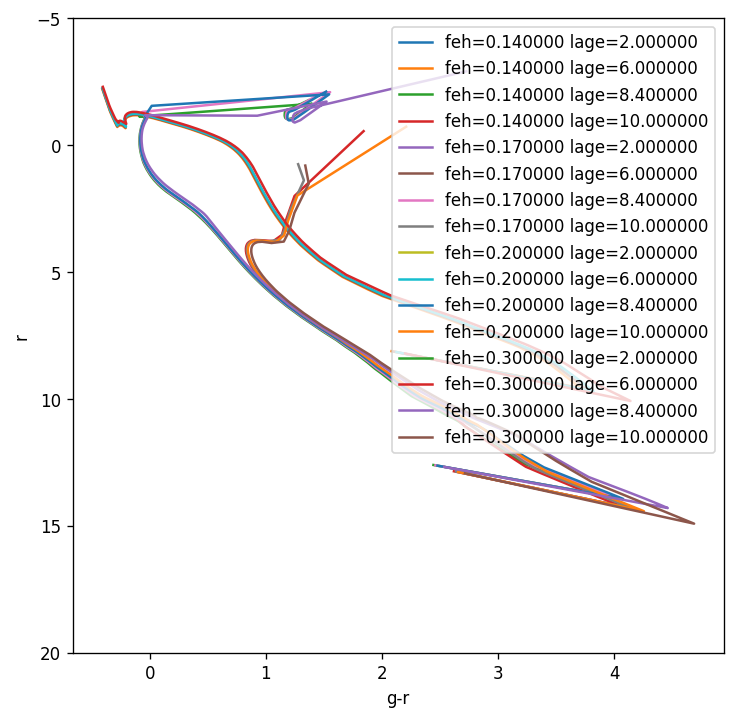

In [4]:
# Compute the isochrones
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = [2,6,8.4,10]
fehgrid = [0.14,0.17,0.2,0.3]
fig = plt.figure(figsize=(7, 7), dpi=120)
for feh in fehgrid:
    for lage in logagegrid:
        iso = ii(massgrid, lage, feh)
        
        x1=iso['Gaia_BP_EDR3'][~np.isnan(iso['Gaia_BP_EDR3'])]
        x2=iso['Gaia_RP_EDR3'][~np.isnan(iso['Gaia_BP_EDR3'])]
        x3=iso['Gaia_G_EDR3'][~np.isnan(iso['Gaia_BP_EDR3'])]
        plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

In [5]:
import os
import pandas as pd
import seaborn as sn

# Import Cluster

Here we look at the high probability elements from our cluster, then we will remove some obvious outliers and set all elements to a commond distance.

In [6]:
os.chdir("../cluster_files")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../Outlier_detection")

#total probability from before.
probability='p3'
cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
scatter=cluster_df[cluster_df[probability]>0.9]
orig_scatter=cluster_df[cluster_df[probability]>0.9]


/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Preparation

### It should be noted that the rgeo was used as the estimate for the distance and does produce something off literature for the cluster.

Here we make a common distance after some cuts on the data.


We make certain cuts here but they definitely have an effect on everything. We will leave in the distance cuts for now.



In [7]:
# Make some cuts that the algo didnt do.
scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
#scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
#set the main distance.
orig_scatter['rgeo']=2.0
def mean_basolute_mag_g_band(selection_gaia):
    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo']*1000)+5   #parsec
    return selection_gaia

mean_basolute_mag_g_band(orig_scatter)
orig_scatter=orig_scatter.sort_values(by=['mean_absolute_mag_g_band'])

Make a small cut on saying most things we care about will have an absolute magnitude less than 17.

In [8]:
scatter=scatter[scatter.mean_absolute_mag_g_band<17.0].reset_index(drop=True) #can I make this cut

### Overlay our cluster points with a few different isochrones

(20.0, -5.0)

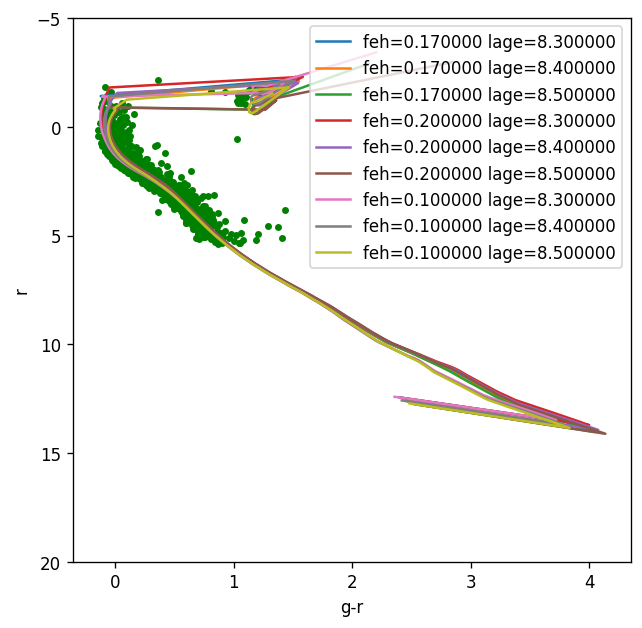

In [9]:
# Compute the isochrones
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = [8.3,8.4,8.5]
fehgrid = [0.17,0.2,0.1]
fig = plt.figure(figsize=(6, 6), dpi=120)
for feh in fehgrid:
    for lage in logagegrid:
        iso = ii(massgrid, lage, feh)
        plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(orig_scatter['bp_rp']-0.6,orig_scatter['mean_absolute_mag_g_band']-1.1,s=10,color='g')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

# Find the Extinction.

In this section we are going to assume that we know the metalicity and age in order to find the extinction. The next line will set an isochrone of the known values.

# Transformations

We know that there is a bias (look at GAIA paper) on selecting stars with bprp<1.2, however we haven't included that here.

In [10]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

In [11]:
orig_scatter['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_g_mean_flux_error']/orig_scatter['phot_g_mean_flux'])**2+0.0027553202**2)
orig_scatter['bp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_bp_mean_flux_error']/orig_scatter['phot_bp_mean_flux'])**2+0.0037793818**2)
orig_scatter['rp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_rp_mean_flux_error']/orig_scatter['phot_rp_mean_flux'])**2+0.0027901700**2)
orig_scatter['bp_rp_error']=np.sqrt(orig_scatter['rp_error']**2+orig_scatter['bp_error']**2)

# Setting up our HR diagram.

In [12]:
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 5000)
logagegrid = [8.5]
fehgrid = [0.17]

In [13]:
iso=ii(massgrid, lage, feh)



(20.0, -5.0)

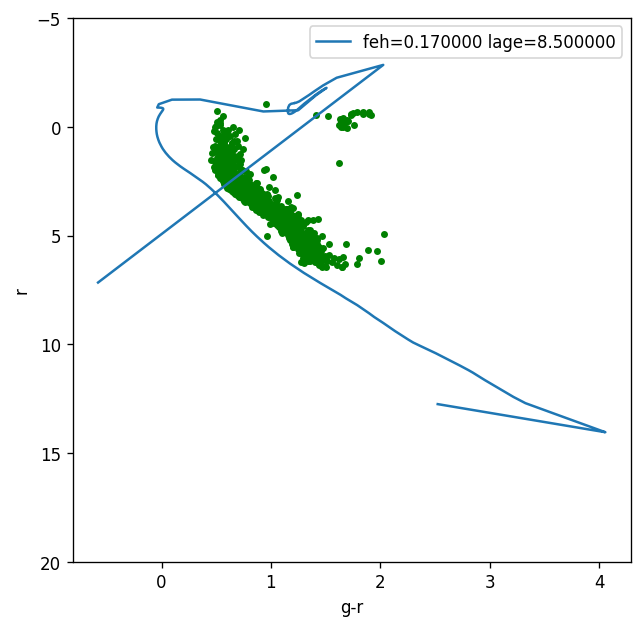

In [14]:
fig = plt.figure(figsize=(6, 6), dpi=120)
for feh in fehgrid:
    for lage in logagegrid:
        iso = ii(massgrid, lage, feh)
        plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

In [15]:
iso['BPRP']=iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
iso['Gaia_G_DR2Rev']=iso['Gaia_G_EDR3']

In [16]:
isochrone=pd.DataFrame()
isochrone['BPRP']=iso['BPRP']
isochrone['Gaia_G_DR2Rev']=iso['Gaia_G_DR2Rev']  #this will be changed later

In [17]:
isochrone=isochrone.dropna()
#isochrone=isochrone[::15].reset_index()

(20.0, -5.0)

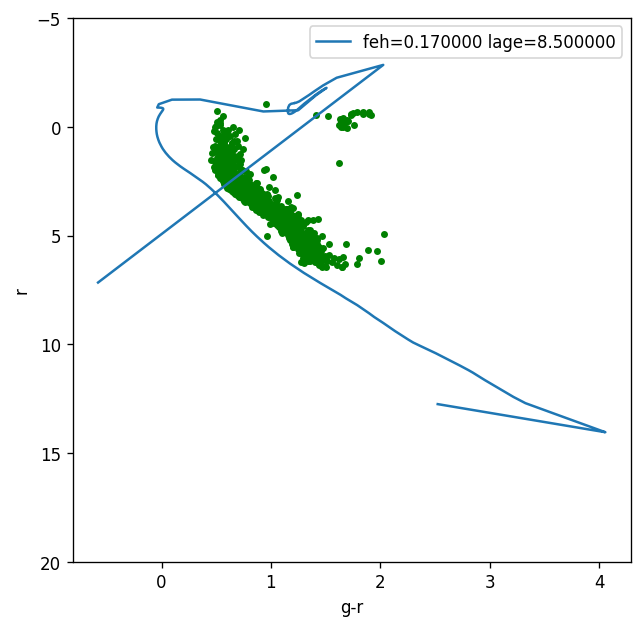

In [18]:
fig = plt.figure(figsize=(6, 6), dpi=120)
plt.plot(isochrone['BPRP'], isochrone['Gaia_G_DR2Rev'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

### Tangent slopes

Next we will find infinitesimal slopes along the isochrone.

In [19]:
p_slopes=[]
x=isochrone['BPRP']
y=isochrone['Gaia_G_DR2Rev']
for i in range(len(isochrone)-1):    
    dy=y[i+1]-y[i]
    dx=x[i+1]-x[i]
    p_slopes.append(-1*dx/dy)
p_slopes.append(0)
isochrone['p_slopes']=p_slopes
isochrone['slopes']=-1/isochrone['p_slopes']

In [20]:
isochrone=isochrone.dropna()

In [21]:
x=orig_scatter['bp_rp']
y=orig_scatter['mean_absolute_mag_g_band']

(20.0, -5.0)

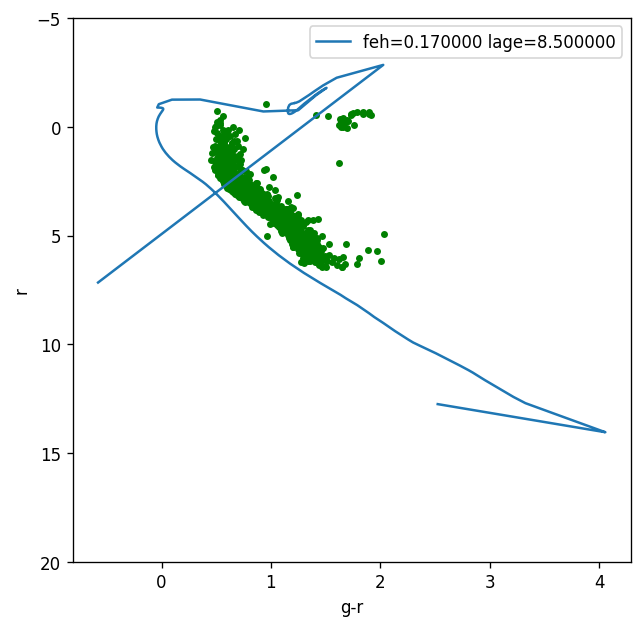

In [22]:
fig = plt.figure(figsize=(6, 6), dpi=120)
plt.plot(isochrone['BPRP'], isochrone['Gaia_G_DR2Rev'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

In [23]:
all_likelihood=[]

#'this is to reset the loop'
x=orig_scatter['bp_rp']
y=orig_scatter['mean_absolute_mag_g_band']

likelihood=[]

isochrone=isochrone.loc()[0:len(isochrone)-2]  





for j in range(13): #y axis loop. Turn to not a loop later

    
    
    likelihood=[]
    for k in range(9): #x axis loop

        scatter=orig_scatter.copy()
        scatter['mean_absolute_mag_g_band']=scatter['mean_absolute_mag_g_band']-0.07*j
        
        scatter['bp_rp']=scatter['bp_rp']-0.1*k
        
        #this is the bound on where we define the perpendicular lines
        #------------------------------------------------------------
        high_c=[]
        low_c=[]
        for n in range(len(isochrone)-1):
            high_c.append(isochrone['Gaia_G_DR2Rev'][n+1] - isochrone['p_slopes'][n]*isochrone['BPRP'][n+1])
            low_c.append(isochrone['Gaia_G_DR2Rev'][n] - isochrone['p_slopes'][n]*isochrone['BPRP'][n])
        high_c.append(0)
        low_c.append(0)
        isochrone['low_c']=high_c #high c is low c oops
        isochrone['high_c']=low_c


        scaler=StandardScaler(with_mean=False,with_std=False)

        
        #i got them the wrong way around but the code works
        #------------------------------------------------------------
        #scaler tranformation
        scaler=StandardScaler(with_mean=False,with_std=False)

        #------------------------------------------------------------
        #should it be true or false on the mean
        #this just takes the final two values away, stops any things with zero slopes at the end.
        #------------------------------------------------------------
        
        
        
        tests=[]
        err_means=[]
        for i in range(len(isochrone)-1):

            
            scatter['y_'+str(i)]=np.nan
            scatter['y_'+str(i)+'_err']=np.nan
            x=(scatter['mean_absolute_mag_g_band']-scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i]) #in correct region lowere bound
            y=(isochrone['low_c'][i]<=scatter['mean_absolute_mag_g_band']-scatter['bp_rp']*isochrone['p_slopes'][i])  #in correct region upper bound
            
            #------------------------------------------------------------
            # Here we get rid of all of the points which have been selected by the algo so far and parse ones 
            test=scatter[x]
            
            test=test[y]
            
            #------------------------------------------------------------
            #We find the random variable mean and variance which correponds to the distance from the line on the isochrone
            #------------------------------------------------------------

            #y proj is the projection onto the colour
            
            if(len(test)>0):
                test['yproj']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))*(1/np.sqrt(1+isochrone['p_slopes'][i]**2))
                test['yproj_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)*(1/(1+isochrone['p_slopes'][i]**2))

                test['y']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))
                test['y_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)
                #------------------------------------------------------------                
                
                #we will then choose the minimum y based on this
                #are these dataframes matching up


                scatter.loc[scatter.index.isin(test.index), 'y_'+str(i)] = test['y'].values
                scatter.loc[scatter.index.isin(test.index), 'y_'+str(i)+'_err']=test['y_err'].values#

                #orig_scatter[orig_scatter.index.isin(test.index)]['y_'+str(i)]=test['y'].values#.replace('nan',0.0).fillna(0.0).astype(float).values
                #orig_scatter[orig_scatter.index.isin(test.index)]['y_'+str(i)+'_err']=test['y_err'].values#.replace('nan',0.0).fillna(0.0).astype(float).values
            else:
                continue
          
                
        columns=['y_'+str(i) for i in range(len(isochrone)-1)]
        scatter['y']=scatter[columns].min(axis=1)
        
        scatter=scatter.dropna(subset=['y'])
        val=scatter[columns].idxmin(axis=1).astype(str)+str('_err')
        scatter['y_err']=scatter.lookup(val.index,val.values)

        flat_test=scatter['y'].values
        flat_testerr=scatter['y_err'].values

        #gmm_GES=XDGMM(2).fit(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
        #prob_ges=gmm_GES.logL(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
        #likelihood.append(prob_ges)
        likelihood.append(np.abs(flat_test).sum())

    all_likelihood.append(np.array(likelihood))    



/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_87958/2436001668.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test=test[y]
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_87958/2436001668.py:103: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  scatter['y_err']=scatter.lookup(val.index,val.values)


In [24]:

xx=np.array(all_likelihood).argmax()//np.array(all_likelihood).shape[0]
yy=np.array(all_likelihood).argmax()%np.array(all_likelihood).shape[0]


(10.0, -5.0)

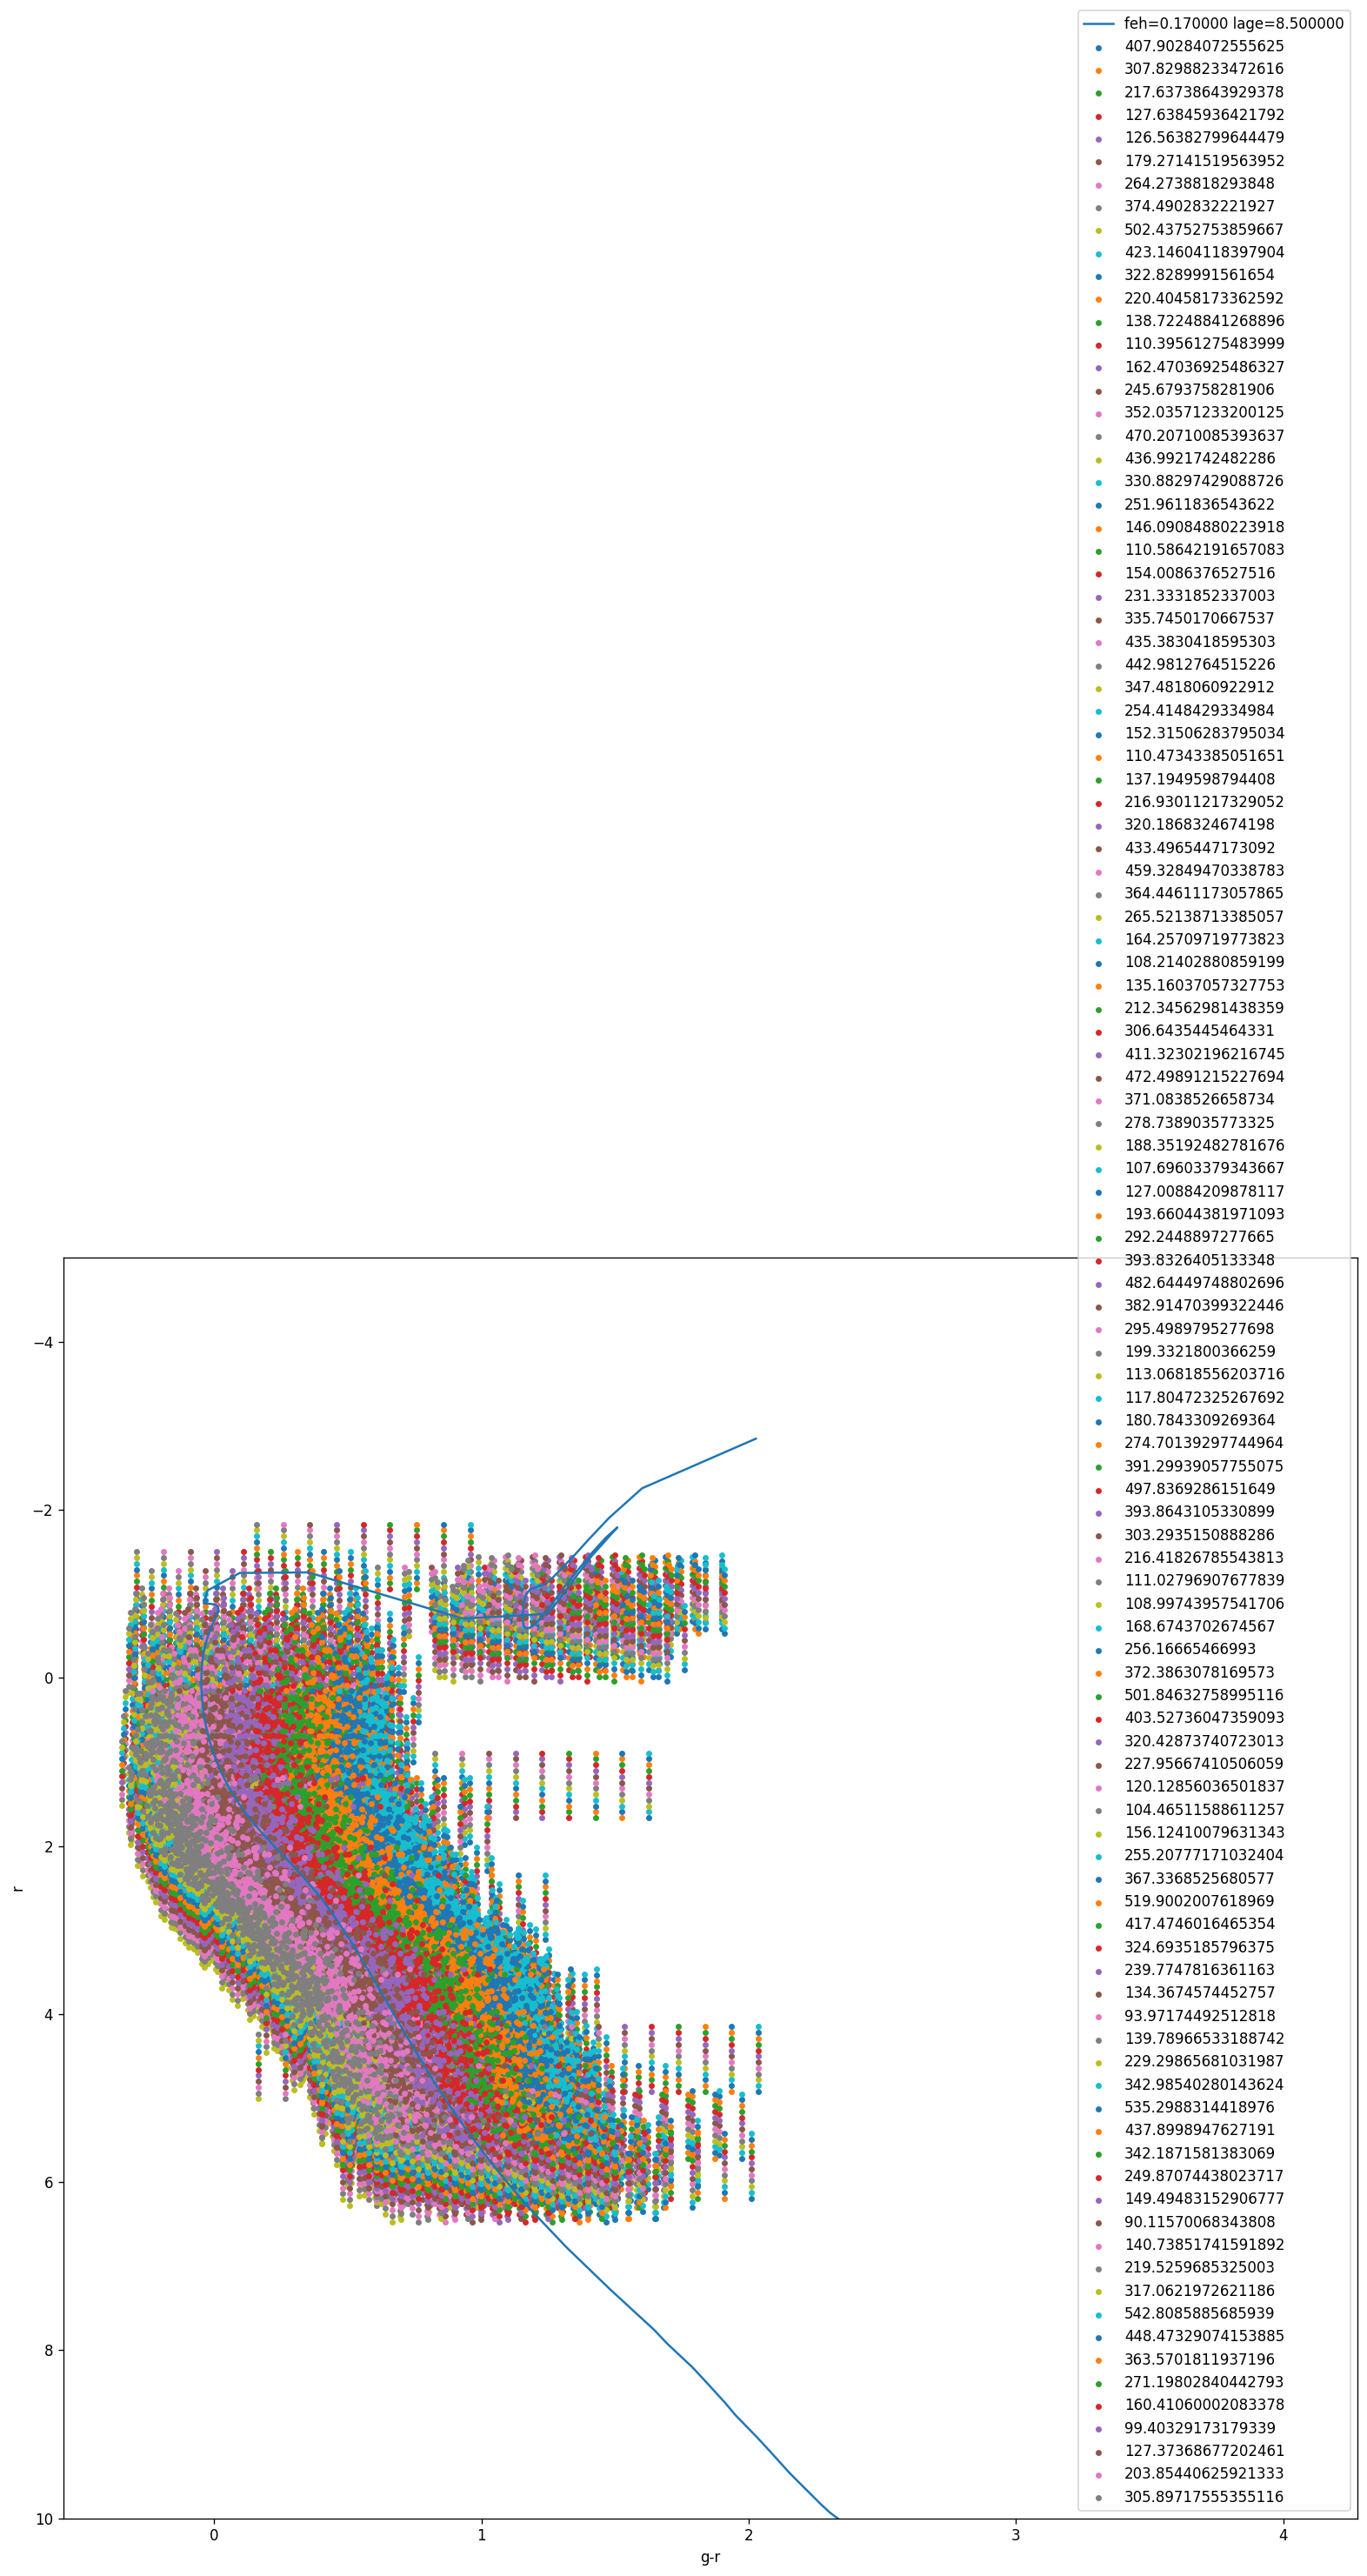

In [25]:

fig = plt.figure(figsize=(16, 16), dpi=120)
plt.plot(isochrone['BPRP'], isochrone['Gaia_G_DR2Rev'],
                 label='feh=%f lage=%f' % (feh, lage))
for j in range(0,12):
    for i in range(9):
        plt.scatter(orig_scatter['bp_rp']-0.1*i,orig_scatter['mean_absolute_mag_g_band']-0.07*j,s=10,label=all_likelihood[j][i])
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(10, -5)

(10.0, -5.0)

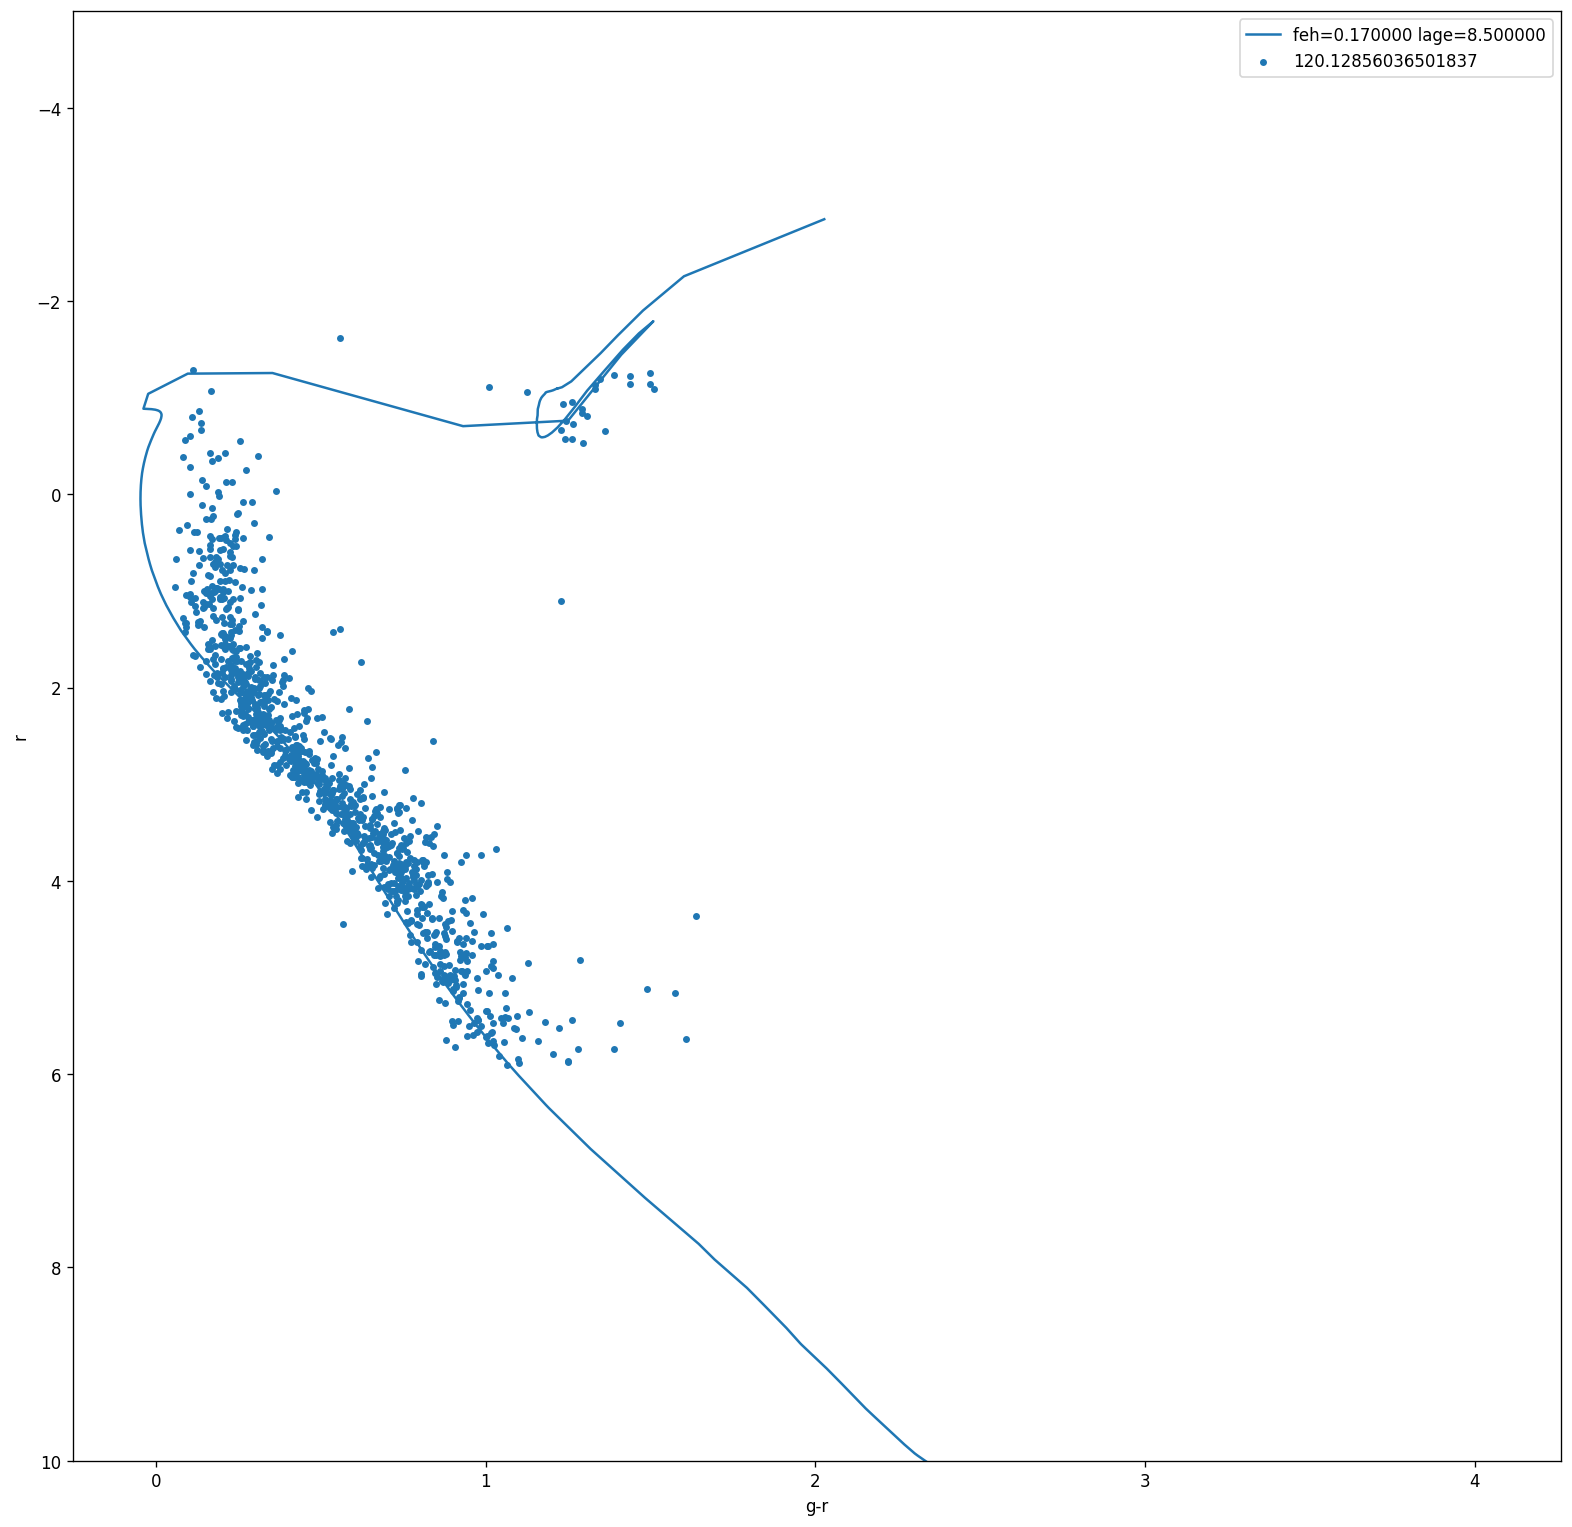

In [26]:

fig = plt.figure(figsize=(16, 16), dpi=120)
plt.plot(isochrone['BPRP'], isochrone['Gaia_G_DR2Rev'],
                 label='feh=%f lage=%f' % (feh, lage))

plt.scatter(orig_scatter['bp_rp']-0.1*yy,orig_scatter['mean_absolute_mag_g_band']-0.07*xx,s=10,label=all_likelihood[xx][yy])
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(10, -5)

(10.0, -5.0)

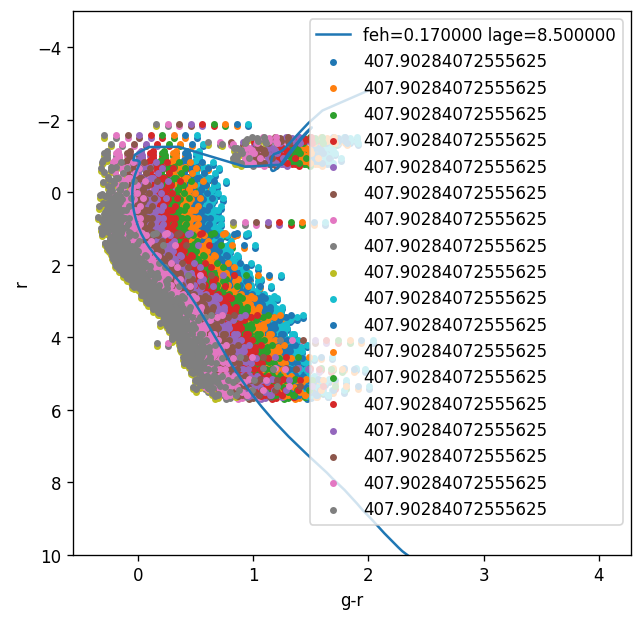

In [27]:

fig = plt.figure(figsize=(6, 6), dpi=120)
plt.plot(isochrone['BPRP'], isochrone['Gaia_G_DR2Rev'],
                 label='feh=%f lage=%f' % (feh, lage))
for j in range(11,13):
    for i in range(9):
        plt.scatter(orig_scatter['bp_rp']-0.1*i,orig_scatter['mean_absolute_mag_g_band']-0.07*j,s=10,label=all_likelihood[0][0])
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(10, -5)